C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Episode 0: Reward = 9.75, Epsilon = 0.9950, LR = 0.001000
Episode 10: Reward = 2.22, Epsilon = 0.9464, LR = 0.001000
Episode 20: Reward = 50.70, Epsilon = 0.9001, LR = 0.001000
Episode 30: Reward = 8.09, Epsilon = 0.8561, LR = 0.001000
Episode 40: Reward = 10.67, Epsilon = 0.8142, LR = 0.001000
Episode 50: Reward = 5.99, Epsilon = 0.7744, LR = 0.001000
Episode 60: Reward = 2.91, Epsilon = 0.7366, LR = 0.001000
Episode 70: Reward = 5.02, Epsilon = 0.7005, LR = 0.001000
Episode 80: Reward = 18.80, Epsilon = 0.6663, LR = 0.001000
Episode 90: Reward = 38.42, Epsilon = 0.6337, LR = 0.001000
Episode 100: Reward = 11.36, Epsilon = 0.6027, LR = 0.000900
Episode 110: Reward = 54.78, Epsilon = 0.5733, LR = 0.000900
Episode 120: Reward = 2.94, Epsilon = 0.5452, LR = 0.000900
Episode 130: Reward = 26.32, Epsilon = 0.5186, LR = 0.000900
Episode 140: Reward = 7.90, Epsilon = 0.4932, LR = 0.000900
Episode 150: Reward = 4.05, Epsilon = 0.4691, LR = 0.000900
Episode 160: Reward = 3.28, Epsilon = 0.4462

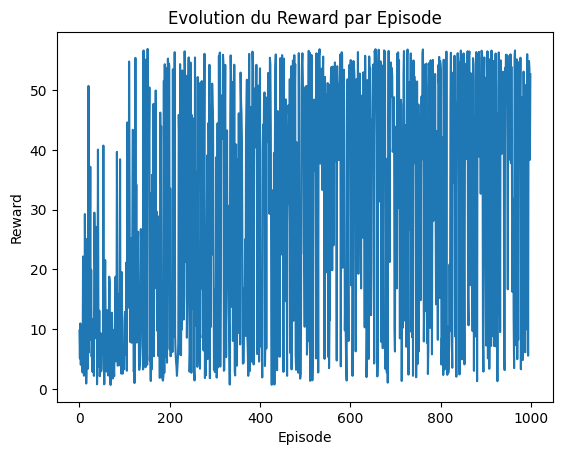

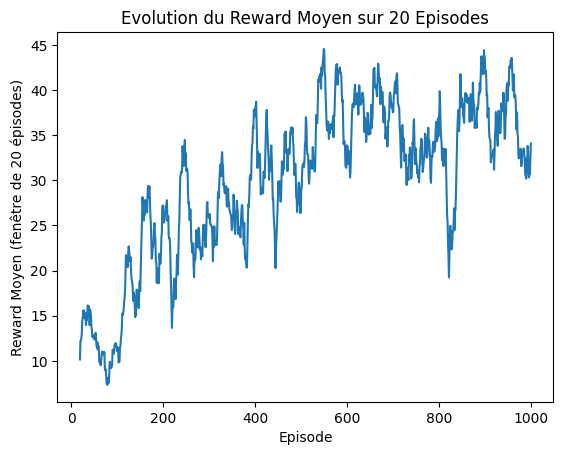

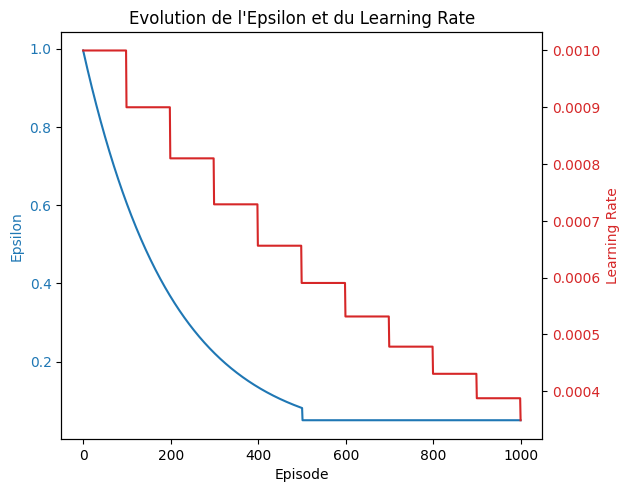

In [6]:
#!/usr/bin/env python3
"""
Implémentation d’un agent Double DQN avec action masking pour l’environnement discrete de Highway.
Ce code intègre également la collecte et la visualisation des courbes :
- Reward par épisode
- Reward moyen sur 20 épisodes
- Évolution de l'epsilon et du learning rate
"""

import gymnasium as gym
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import highway_env

# Chargement de la configuration
with open("config/1-highway-discrete-config.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make("highway-fast-v0", render_mode="human")
env.unwrapped.configure(config)
observation, _ = env.reset()

# --------------------------------------------------------------------------
# Fonctions d'aide
# --------------------------------------------------------------------------
def is_risky(state):
    """
    Détermine si l'état (observation) présente un risque pour l'accélération.
    L'observation est issue d'une grille d'occupation.
    On considère risqué si, dans la colonne la plus à droite de la grille, une cellule
    indique la présence d'un véhicule (valeur > 0.5).
    """
    grid_range = config["observation"]["grid_size"][0]
    grid_step = config["observation"]["grid_step"][0]
    nx = int((grid_range[1] - grid_range[0]) / grid_step)
    ny = int((config["observation"]["grid_size"][1][1] - config["observation"]["grid_size"][1][0]) / config["observation"]["grid_step"][1])
    
    num_features = 7  # ['presence', 'x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']
    
    if state.size != nx * ny * num_features:
        return False
    grid = state.reshape(nx, ny, num_features)
    front_presence = grid[-1, :, 0]
    return np.any(front_presence > 0.5)

def shape_reward(reward, action, state):
    """
    Applique le reward shaping :
      - Renforce la pénalité en cas de collision.
      - Applique un malus si l'action est d'accélérer dans un contexte risqué.
      - Un offset de +0.5 est ajouté pour équilibrer le signal.
    """
    shaped = reward
    if reward <= config.get("collision_reward", -1):
        shaped = reward * 2
    if action == 1 and is_risky(state):
        shaped -= 0.5
    return shaped

# --------------------------------------------------------------------------
# Définition du réseau de neurones (DQN)
# --------------------------------------------------------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --------------------------------------------------------------------------
# Définition de l'agent (Double DQN avec action masking)
# --------------------------------------------------------------------------
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)

        self.replay_buffer = deque(maxlen=100000)

        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.action_dim = action_dim

    def get_action(self, state):
        # Exploration avec masquage d'action
        if np.random.rand() < self.epsilon:
            available_actions = list(range(self.action_dim))
            if is_risky(state) and 1 in available_actions:
                available_actions.remove(1)
                if len(available_actions) == 0:
                    available_actions = [1]
            return random.choice(available_actions)
        # Exploitation : modification des Q-values en contexte risqué
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_tensor).squeeze(0).numpy()
        if is_risky(state):
            q_values[1] = -float('inf')
        return int(np.argmax(q_values))
    
    def update_epsilon(self, current_episode, total_episodes):
        # À partir de la moitié des épisodes, epsilon est fixé au minimum
        if current_episode > total_episodes // 2:
            self.epsilon = self.epsilon_min
        else:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():
            next_actions = self.q_net(next_states).argmax(dim=1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target = rewards + self.gamma * (1 - dones) * next_q_values

        loss = F.mse_loss(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# --------------------------------------------------------------------------
# Fonction de training avec collecte de métriques
# --------------------------------------------------------------------------
def train(agent, env):
    all_rewards = []
    epsilon_values = []
    lr_values = []
    num_episodes = 1000      # Nombre d'épisodes
    sync_target_every = 10  # Synchronisation du réseau cible

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = state.flatten()
        total_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = next_state.flatten()
            done = terminated or truncated

            shaped_reward = shape_reward(reward, action, state)
            agent.replay_buffer.append((state, action, shaped_reward, next_state, done))
            agent.update()

            state = next_state
            total_reward += reward  # cumule la reward d'origine

        # Mise à jour de l'epsilon et enregistrement des métriques
        agent.update_epsilon(ep, num_episodes)
        epsilon_values.append(agent.epsilon)
        agent.scheduler.step()
        current_lr = agent.optimizer.param_groups[0]['lr']
        lr_values.append(current_lr)
        all_rewards.append(total_reward)

        if ep % sync_target_every == 0:
            agent.target_net.load_state_dict(agent.q_net.state_dict())

        if ep % 10 == 0:
            print(f"Episode {ep}: Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.4f}, LR = {current_lr:.6f}")

    return all_rewards, epsilon_values, lr_values

# --------------------------------------------------------------------------
# Fonctions de visualisation
# --------------------------------------------------------------------------
def plot_reward_per_episode(all_rewards):
    plt.figure()
    plt.plot(range(len(all_rewards)), all_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Evolution du Reward par Episode")
    plt.show()

def plot_moving_average(all_rewards, window_size=20):
    moving_avg = np.convolve(all_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.figure()
    # On décale l'axe des x pour correspondre au début de la fenêtre
    plt.plot(range(window_size - 1, len(all_rewards)), moving_avg)
    plt.xlabel("Episode")
    plt.ylabel("Reward Moyen (fenêtre de 20 épisodes)")
    plt.title("Evolution du Reward Moyen sur 20 Episodes")
    plt.show()

def plot_epsilon_lr(epsilon_values, lr_values):
    fig, ax1 = plt.subplots()

    color_epsilon = 'tab:blue'
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Epsilon", color=color_epsilon)
    ax1.plot(range(len(epsilon_values)), epsilon_values, color=color_epsilon, label="Epsilon")
    ax1.tick_params(axis='y', labelcolor=color_epsilon)

    ax2 = ax1.twinx()  # Création d'un second axe y
    color_lr = 'tab:red'
    ax2.set_ylabel("Learning Rate", color=color_lr)
    ax2.plot(range(len(lr_values)), lr_values, color=color_lr, label="Learning Rate")
    ax2.tick_params(axis='y', labelcolor=color_lr)

    fig.tight_layout()
    plt.title("Evolution de l'Epsilon et du Learning Rate")
    plt.show()

# --------------------------------------------------------------------------
# Partie principale
# --------------------------------------------------------------------------
if __name__ == "__main__":
    # Dimensions de l'état et nombre d'actions
    state_dim = observation.flatten().shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)
    all_rewards, epsilon_values, lr_values = train(agent, env)

    # Affichage des graphiques
    plot_reward_per_episode(all_rewards)
    plot_moving_average(all_rewards, window_size=20)
    plot_epsilon_lr(epsilon_values, lr_values)


In [4]:
import matplotlib.pyplot as plt